Recently, I fortuitously came across an [interesting blog post](https://peterroelants.github.io/posts/multi-armed-bandit-implementation/) on the multi-armed bandit problem, or MAB for short. I say fortuitous because the contents of this blog nicely coincided with a post I had meant to write for a very long time: revisiting the Beta distribution, conjugate priors, and all that good stuff. I decided that the MAB would be a refreshing way to discuss this topic. "Bayesian" is a buzz word that statisticians and ML people love anyway, me shamelessly included.

In this post, we will start off with a brief introduction into what the MAB problem is, why it is relevant, and how we can use some basic Bayesian analysis with Beta and Bernoulli distributions to derive a nice sampling algorithm, known as Thompson sampling. Let's dive right into it.

# Problem Setup

The multi-armed bandit problem is a classical gambling setup in which a gambler has the choice of pulling the lever of any one of $k$ slot machines, or bandits. The probability of winning for each slot machine is fixed, but of course the gambler has no idea what these probabilities are. To ascertain out the values of these parameters, the gambler must learn through some trial and error. Given this setup, what is the optimal way of going about the problem? One obvious way is to start randomly pulling on some slot machines until they get a rough idea of what the success probabilities are. However, this is obviously not the most systematic approach, and there is not even a clear guideline as to how they should go about pulling these levers. 

Here is where the Bayesian approach comes in handy. It isn't difficult to frame this as a Bayesian problem. Given a pull of the slot machine, the result of which we will denote as $x$, a Bernoulli random variable, we can then formulate the problem as follows: 

$$
P(\theta \vert x) = \frac{P(x \vert \theta) P(\theta)}{P(x)} \tag{1}
$$

And as the classical Bayesian analysis goes, the more data we collect through repeated experiments, the closer the posterior distribution will get to the target distribution. Through this process, we are able to approximate the parameter $\theta$. 

Now we have to think about what distributions we want to use for the prior and likelihood. Let's start with the easier one: the likelihood. The natural choice that makes sense is the binomial distribution. Each pull on the lever can be considered a Bernoulli trial, and as we start exploring with more pulls to accumulate data, we will essentially be sampling from a binomial distribution, with $s$ success and $f$ failures out of a total of $(s + f)$ trials. Therefore, more concretely, we can say

$$
P(s, f \vert \theta) = \binom{s + f}{s} \theta^s (1 - \theta)^f \tag{2}
$$



The more interesting part is the prior distribution. Intuitively, the one might be inclined to say that we need a uniform prior, and indeed that answer would technically be true. However, I qualify with "technically" since the real answer has an added layer of complexity. Having a uniform prior only makes sense on the very first try, when there is no historical data to estimate the parameter from. However, once we start pulling the lever and seeing the results of each consecutive pull, we should be able to build some prior expectation as to what the true value of the parameter is. This suggests that the uniform prior approach is missing some important key pieces.

To really drive this point home, let's discuss more about the notion of conjugate priors, specifically in the context of the Beta and binomial distributions.

# Beta-Binomial 

The notion of conjugate priors is something that recurs extremely often in Bayesian analysis. This is mainly because conjugate priors offer a nice closed-form solution to posterior distribution computation. Simply put, a conjugate prior to some likelihood function is a type of prior that, when multiplied with a given likelihood, produces a posterior distribution that is of the same form as itself. For example, a Beta prior, when multiplied with a binomial likelihood, produces a Beta posterior. This is what we want in Bayesian analysis, since we can now assume that posterior to be our new prior in the next iteration of experiments. 

In this section, we will build on top of this high level understanding of conjugacy to show that a Beta distribution is indeed a conjugate prior to the binomial likelihood function. On that end, let's start with a quick definition review of the Beta distribution and the Beta function.

## Beta Distribution

The Beta distribution looks as follows:

$$
f(x; \alpha, \beta) = \frac{1}{\text{B}(\alpha, \beta)} x^{\alpha - 1} (1 - x)^{\beta - 1} \tag{3}
$$

where 

$$
\begin{align}
\text{B}(\alpha, \beta) 
&= \frac{\Gamma(\alpha) \Gamma(\beta)}{\Gamma(\alpha + \beta)} \\
&= \int_{0}^1 x^{\alpha - 1} (1 - x)^{\beta - 1} \, dx
\end{align} \tag{4}
$$

Comparing (3) and the integral representation of the Beta function in (4), you will see that there is a clear resemblance, and this is no coincidence. In the Beta distribution, the Beta function which appears in the denominator is simply a normalizing constant that ensures that integrating the probability distribution function from 0 to 1 produces 1.

The specifics of the Beta function and how it relates to the Gamma function might be a topic for a another post. For now, it suffices to show the general probability function as well as its building blocks, namely the Beta function itself. These will become relevant later when we derive the posterior with a binomial likelihood function to show conjugacy.

## Conjugacy

To prove conjugacy, it suffices to show that multiplying a Beta prior with a binomial likelihood produces a Beta posterior. Roughly speaking, the big picture we will be using is essentially equation (1). 

$$
\begin{align}
P(\theta \vert s, f)
&= \frac{P(s, f \vert \theta) P(\theta; \alpha, \beta)}{\int_0^1 P(s, f \vert \theta) P(\theta; \alpha, \beta) \, d \theta}
\end{align} \tag{5}
$$

For notation consistency, I decided to use $\vert$ for conditional probability and $;$ for function parametrization. For a rather pedantic discussion on this notational convention, I recommend that you take a quick look at [this cross validated post](https://stats.stackexchange.com/questions/10234/meaning-of-probability-notations-pzd-w-and-pzd-w). 

Let's now plug in the Beta and binomial distributions into (5) to see what comes out of it. This is going to be a lot of computation, but the nice part of it is that a lot of terms cancel out each other.

$$
P(\theta \vert s, f) = \frac{\binom{s + f}{s} \theta^s (1 - \theta)^f \frac{1}{\text{B}(\alpha, \beta)} \theta^{\alpha - 1} (1 - \theta)^{\beta - 1}}{\int_0^1 \binom{s + f}{s} \theta^s (1 - \theta)^f \frac{1}{\text{B}(\alpha, \beta)} \theta^{\alpha - 1} (1 - \theta)^{\beta - 1} \, d \theta} \tag{6}
$$

We can easily see that there are constant that exist both in the numerator and the denominator. We can pull these constants out of the integral to simplify the expression. These constants include the binomial and the reciprocal Beta normalizing constants. 

$$
\begin{align}
P(\theta \vert s, f) 
&= \frac{\theta^s (1 - \theta)^f \theta^{\alpha - 1} (1 - \theta)^{\beta - 1}}{\int_0^1 \theta^s (1 - \theta)^f  \theta^{\alpha - 1} (1 - \theta)^{\beta - 1} \, d \theta} \\
&= \frac{\theta^{s + \alpha - 1} (1 - \theta)^{f + \beta - 1}}{\int_0^1 \theta^{s + \alpha - 1} (1 - \theta)^{f + \beta - 1} \, d \theta} 
\end{align} \tag{7}
$$

One useful observation to make here is the fact that the numerator itself looks a lot like something we have seen before: the Beta distribution. In fact, you might also realize that the denominator is nothing but just a normalizing constant that ensures that our posterior distribution, when integrated from 0 to 1, integrates up to 1 as the axiom of probability states. We can also see the denominator as the definition of the Beta function. In other words, 

$$
\int_0^1 \theta^{s + \alpha - 1} (1 - \theta)^{f + \beta - 1} \, d \theta = \text{B}(s + \alpha, f + \beta) \tag{8}
$$

Therefore, we end up with 

$$
\begin{align}
P(\theta \vert s, f) 
&= \frac{1}{\text{B}(s + \alpha, f + \beta)} \theta^{s + \alpha - 1} (1 - \theta)^{f + \beta - 1} \\
&= \text{Beta}(s + \alpha, f + \beta)
\end{align} \tag{9}
$$

Notice that offers an extremely nice interpretation: the number of success $s$ and failures $f$, which are determined by $\theta$, yield insight into what the true parameter is via the Beta distribution. This is why the Beta distribution is often referred to as a "probability distribution of probabilities." I highly recommend that you read [this post on cross validated](https://stats.stackexchange.com/questions/47771/what-is-the-intuition-behind-beta-distribution/47782#47782) for many intuitive explanations of what the Beta distribution is and how it can be useful, such as in this Bayesian context. 

## Mean

Now we know that there is a closed-form solution for Bayesian problems involving conjugate priors and likelihood functions, such as a Beta prior coupled with the binomial likelihood. But we want to be able to interpret the posterior distribution. We might start from rather simple metrics like the mean to get a better idea of what the posterior tells us. Note that we can always generalize such quantities into moments. 

Given $X \sim \text{Beta}(\alpha, \beta)$, the expected value of the Beta random variable can be expressed as

$$
\mathbb{E}[X] = \frac{\alpha}{\alpha + \beta} \tag{10}
$$

Proving this is pretty straightforward if we simply use the law of the unconscious statistician. Using the definition of expectation, we can derive the following:

$$
\begin{align}
\mathbb{E}[X] 
&= \int_0^1 \frac{x}{\text{B}(\alpha, \beta)} x^{\alpha - 1} (1 - x)^{\beta - 1} \\
&= \frac{1}{\text{B}(\alpha, \beta)} \int_0^1 x^\alpha (1 - x)^{\beta - 1} \\
&= \frac{\text{B}(\alpha + 1, \beta)}{\text{B}(\alpha, \beta)} 
\end{align} \tag{11}
$$

Here, we use the Gamma representation of the Beta function. 

$$
\begin{align}
\mathbb{E}[X] 
&= \frac{\text{B}(\alpha + 1, \beta)}{\text{B}(\alpha, \beta)} \\
&= \frac{\Gamma(\alpha + 1) \Gamma(\beta)}{\Gamma(\alpha + \beta + 1)} \cdot \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)} \\
&= \frac{\alpha}{\alpha + \beta}
\end{align} \tag{12}
$$

This conclusion gives an even nicer, more intuitive interpretation of the Bayesian update we saw earlier with the Beta prior and binomial likelihood. Namely, given the new posterior

$$
X \sim \text{Beta}(s + \alpha, f + \beta)
$$

we know that sampling from that new posterior will give us a mean value that somewhat resembles the crude approach we would have taken without the prior expectation. 

$$
\mathbb{E}[X] = \frac{s + \alpha}{s + f + \alpha + \beta}
$$


Here, the crude approach is referring to the raw frequentist estimate we would have made had we not taken the Bayesian approach to the problem. 

$$
\frac{s}{s + f}
$$

It is obvious that the two hyperparameters of the prior are acting as an initial weight of sorts, making sure that when little data is available, the prior overshadows observations, but when ample amount of data is collected and available, eventually yields to those observations to estimate the parameter.

# Code Implementation

Now we can turn our attention back to the multi-armed bandit problem. Now we can build on top of our knowledge of the Beta-Binomial update and refine what the frequentist greedy approach. We will also write out some simple functions to simulate the bandit problem and thus demonstrate the effectiveness of the Bayesian approach. Note that a lot of the code in this post was largely inspired by [Peter's blog](https://peterroelants.github.io/posts/multi-armed-bandit-implementation/). 

## Bandit Simulation

Before we get into any modeling, let's first import the modules we'll need and set things up.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("ggplot")
np.random.seed(123)

Instead of using the approach outlined in the blog I've linked to, I decided to use objects to model bandits. The rationale is that this approach seems to make a little bit more intuitive sense to me. Also, working with Django these days has made me feel more affinity with Python classes. At any rate, let's go ahead.

In [2]:
class Bandit:
    def __init__(self, theta):
        self.history = []
        self.posterior = [1, 1]
        self.theta = theta
        
    def pull(self):
        result = 1 if self.theta > np.random.rand() else 0
        self.history.append(result)
        self.posterior[1 - result] += 1

Now, we can initialize a bandit with some predetermined parameter, `theta`. Of course, our goal would be to determine the true value of this parameter through sampling and Bayesian magic. In this case, we have created a fair bandit with a `theta` of 0.5.

In [3]:
test_bandit = Bandit(0.5)
test_bandit.theta

0.5

We can also simulate level pulls by repeatedly calling on `test_bandit.pull()`. Note that this will accumulate the result of each Bernoulli trial in the `self.history` list object. 

In [4]:
for _ in range(10):
    test_bandit.pull()

test_bandit.history

[0, 1, 1, 0, 0, 1, 0, 0, 1, 1]

Notice that we also have `self.posterior`. This is an a list object that c

Now that we have performed all the basic sanity checks we need, let's quickly go ahead and create three bandit objects for demonstration purposes. 

In [5]:
parameters = [0.45, 0.55, 0.7, 0.1]
bandits = [Bandit(theta) for theta in parameters]

## Thompson Sampling

Now we get into the details of how to perform the Bayesian update. More specifically, we're interested in how we are going to use posterior probabilities to make decisions on which slot machine to pull on. 

This is where Thompson sampling comes in. In the simple, greedy frequentist approach, we would determine which bandit to pull on given our historical rate of success. If the first slot machine approximately yielded success 60 percent of the time, whereas the second one gave us 40, we would choose the first. Of course, this approach is limited by the fact that, perhaps we only pulled on the second machine 5 times and got only 2 success out of them, whereas we pulled on the first bandit a hundred times and got 60 successes. Maybe it turns out that the second bandit actually has a higher success rate, and that we were simply unlucky those five turns. 

Thompson sampling remedies this problem by suggesting a different approach: now that we have Bayesian posteriors, we can now directly sample from those posteriors to get an approximation of the parameter values. Since we are sampling from a distribution instead of relying on a point estimate as we do for the greedy approach, this allows for both exploration and exploitation to happen at reasonable frequencies. If a posterior distribution has large variance, this means that we will explore that particular bandit slightly more than others. If a posterior has a large mean---a high success parameter---then we will exploit that machine a bit more to earn more profit, or, in this context, to minimize regret.

## Regret

Before we move on any farther, perhaps' it's worth discussing what the term "regret" means in this context. Simply put, regret refers to the amount that we have comparatively lost by making a sub-optimal choice from the get go. Here is a visual diagram I came across on [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2018/09/reinforcement-multi-armed-bandit-scratch-python/).

<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2018/09/im_9.jpg'>

The maximum reward would obviously be achieved if we pull on the slot machine with the highest success parameter from trial 1. However, this does not happen since the gambler dives into the game without this prior knowledge. Hence, they have to learn what the optimal choice is through exploration and exploitation. It is of course in this learning process that the greedy algorithm or Bayesian analysis with Thompson sampling comes into play. The amount that we have theoretically lost---or, in other words, the extent to which we are far away from the maximum amount we could have earned---is denoted as regret. Thus, to maximize reward is to minimize regret, and vice versa.

## Simulation Analysis

Now let's simulate a hundred pulls on the lever using Bayesian analysis using the Beta-Binomial model and Thompson sampling. Nothing much fancy here, all we're doing is Thompson sampling from the Beta distribution via `np.random.beta`, then obtaining the index of the bandit with the highest parameter, then pulling the machine that corresponds to that index. We will also keep cumulative track of our results to reproduce the regret diagram shown above.

In [6]:
num_trials = 100
reward_history = [0]

for _ in range(num_trials):
    index = np.argmax(
        [np.random.beta(*bandit.posterior) for bandit in bandits]
    )
    bandits[index].pull()
    reward_history.append(reward_history[-1] + bandits[index].history[-1])

And we're done with the hundred round of simulations! Hopefully our simulator gambler has made some good choices by following Bayesian update principles, with the Beta-Binomial model and Thompson sampling under their belt.

Let's take a look at the posterior distribution for each bandit. We can easily plot them using `scipy`, as shown below. Notice that I have also included the uniform prior for reference purposes. 

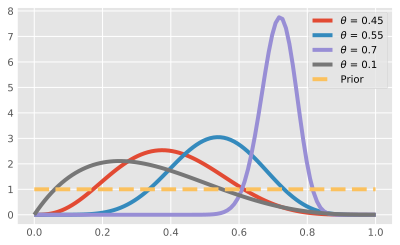

In [41]:
x = np.linspace(0, 1, 100)

for bandit in bandits:
    plt.plot(
        x, beta.pdf(x, *bandit.posterior), label=f"$\\theta$ = {bandit.theta}"
    )
plt.plot(x, beta.pdf(x, 1, 1), "--", label="Prior")
plt.legend()
plt.show()

The result is as we would expect: the bandit with the highest success parameter of 0.7 seems to have been pulled on the most, which explains why its variance is the smallest out of the bunch. Moreover, the mean of that particular posterior is also close to 0.7, its true value. Notice that the rest of the posteriors also somewhat have this trend, although more uncertainty is reflected into the shape of the distributions via the spread. It is interesting to see how we can go from a uniform prior, or $\text{Beta}(1, 1)$, to almost normal-shaped distributions as we see above.

To corroborate our intuition that the best bandit was indeed the most pulled, let's quickly see the proportion of the pulls through a pie chart.

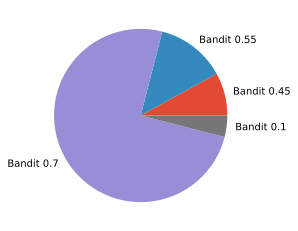

In [19]:
sizes = [len(bandit.history) for bandit in bandits]
labels = [f"Bandit {bandit.theta}" for bandit in bandits]
plt.pie(sizes, labels=labels)
plt.show()

As you can see, there seems to be a positive correlation between the success parameter and the number of pulls. This is certainly good, since we want the gambler to pull on the best bandit the majority of times while avoiding the worse ones as much as possible. This certainly seems to be the case, given that the bandit with the worse parameter---0.1---was pulled the least.

Last but not least, let's revisit the cumulative regret graph introduced earlier. We can draw our own cumulative regret graph by first simulating what would have been the optimal result---in other words, we need to obtain the amount of reward the gambler would have earned had they simply pulled on the best bandit the entire time. Let's quickly simulate that first.

In [8]:
maximum_reward = 0
best_theta = np.max(parameters)

for _ in range(num_trials):
    result = int(best_theta > np.random.rand())
    maximum_reward += result

maximum_reward_graph = [maximum_reward] * (num_trials + 1)

And it turns out that the maximum amount they would have earned, in this particular instance, is 74. I say in this particular instance, since the expected value of the maximum reward is simply 70, given that the highest success parameter is 0.7.

In [42]:
maximum_reward

74

This minor detail notwithstanding, we can now use the `maximum_reward` quantity and the `reward_history` list in order to recreate our own cumulative regret graph, as shown below.

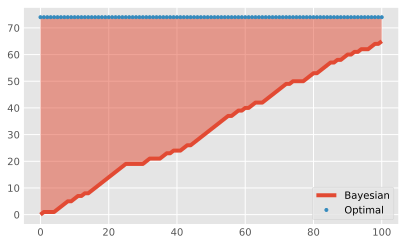

In [21]:
trials = range(num_trials + 1)
plt.plot(trials, reward_history, label="Bayesian")
plt.plot(trials, maximum_reward_graph, ".", label="Optimal")
plt.fill_between(trials, reward_history, maximum_reward_graph, alpha=0.5)
plt.legend()
plt.show()

It is obvious that the cumulative regret is highest when we start since the current reward is at 0. However, after some trial and error, the gambler starts to figure out which bandit is the best and starts pulling more of those, ultimately ending up at the point that is quite close to the maximum reward, though not quite due to the earlier opportunities that may have been lost due to exploration and sampling. 

# Conclusion

In this post, we took a look at the multi-armed bandit problem and how it relates to Bayesian analysis with the Beta and Binomial distributions. I personally enjoyed writing this post, not only because I hadn't written in a long time, but also because it helped me revisit some statistics, which is something that I desperately needed to do---I'm spending way too much time dealing with Django and Selenium these days. 

Time and again, I realize that there is an element of intuitiveness to Bayesian statistics that, though not obvious at first, starts to make more sense as I explore more into that realm. Of course, frequentist statistics offers a quick and easy way of interpreting certain metrics, but the notion of expectation is something that I had thought was complicated and unnecessary at first, but have gradually come to understand, embrace, and even support. Perhaps writing this post has reaffirmed my Bayesian identity as a budding statistician. 

I hope you've enjoyed reading this post. Catch you up in the next one!